# XSection

This notebook reproduces the cross-section analysis written by Jebb Stewart in order to better understand the steps and prepare to implement it as a backend service for the HRRR Smoke XSection application.

In [1]:
import json

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

In [2]:
dataset = xr.open_zarr("data/sample.zarr")
dataset

<xarray.Dataset>
Dimensions:         (hybrid: 50, y: 1059, x: 1799)
Coordinates:
  * hybrid          (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
    latitude        (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude       (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    reference_time  datetime64[ns] ...
    valid_time      datetime64[ns] ...
  * x               (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y               (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
Data variables:
    gh_hybrid       (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    massden         (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    massden_hybrid  (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    pres_hybrid     (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    q_hybrid        (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    t_hybrid        (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

## Projection

Convert the x-y coordinates in the dataset to a Labert Conformal projection.

In [3]:
cf_attrs = {
    'grid_mapping_name': 'lambert_conformal_conic',
    'standard_parallel': 38.5,
    'longitude_of_central_meridian': -97.5,
    'latitude_of_projection_origin': 38.5
}

In [4]:
dataset = dataset.metpy.assign_crs(cf_attrs).metpy.parse_cf().squeeze()
dataset

<xarray.Dataset>
Dimensions:         (hybrid: 50, y: 1059, x: 1799)
Coordinates:
  * hybrid          (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
    latitude        (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude       (y, x) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    reference_time  datetime64[ns] 2021-09-22
    valid_time      datetime64[ns] 2021-09-22T02:00:00
  * x               (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y               (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
    metpy_crs       object Projection: lambert_conformal_conic
Data variables:
    gh_hybrid       (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    massden         (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    massden_hybrid  (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    pres_hybrid     (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    q_hybrid        (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    t_hybrid        (hybrid, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

## Generate Cross-section

Define the path over which to generate the cross-section.

In [5]:
startPoint = (32.55, -117.03)
endPoint = (41.95, -122.87)
steps = 1200

In [6]:
cross = metpy.interpolate.cross_section(dataset, startPoint, endPoint, steps).set_coords(("latitude", "longitude"))
cross

<xarray.Dataset>
Dimensions:         (hybrid: 50, index: 1200)
Coordinates:
  * hybrid          (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 47.0 48.0 49.0 50.0
    latitude        (index) float64 32.56 32.57 32.57 ... 41.92 41.93 41.94
    longitude       (index) float64 -117.1 -117.1 -117.1 ... -122.9 -122.9
    reference_time  datetime64[ns] 2021-09-22
    valid_time      datetime64[ns] 2021-09-22T02:00:00
    metpy_crs       object Projection: lambert_conformal_conic
    x               (index) float64 -1.83e+06 -1.83e+06 ... -2.081e+06
    y               (index) float64 -4.664e+05 -4.655e+05 ... 6.71e+05 6.719e+05
  * index           (index) int64 0 1 2 3 4 5 ... 1194 1195 1196 1197 1198 1199
Data variables:
    gh_hybrid       (hybrid, index) float32 dask.array<chunksize=(1, 1200), meta=np.ndarray>
    massden         (index) float32 dask.array<chunksize=(1200,), meta=np.ndarray>
    massden_hybrid  (hybrid, index) float32 dask.array<chunksize=(1, 1200), meta=np.ndarray>
    pres_hybrid     (hybrid, index) float32 dask.array<chunksize=(1, 1200), meta=np.ndarray>
    q_hybrid        (hybrid, index) float32 dask.array<chunksize=(1, 1200), meta=np.ndarray>
    t_hybrid        (hybrid, index) float32 dask.array<chunksize=(1, 1200), meta=np.ndarray>

In [7]:
plevs = np.arange(1000.0,100,-20.0, dtype=np.float32) * metpy.units.units.hPa
plevs

Magnitude,[1000.0 980.0 960.0 940.0 920.0 900.0 880.0 860.0 840.0 820.0 800.0 780.0 760.0 740.0 720.0 700.0 680.0 660.0 640.0 620.0 600.0 580.0 560.0 540.0 520.0 500.0 480.0 460.0 440.0 420.0 400.0 380.0 360.0 340.0 320.0 300.0 280.0 260.0 240.0 220.0 200.0 180.0 160.0 140.0 120.0]
Units,hectopascal


In [8]:
temperature = metpy.units.units.Quantity(cross["t_hybrid"].values, "degK")
temperature

Magnitude,[[294.55921079655946 294.5578006065536 294.5554461867374 ... 293.61959433413324 293.85678388598205 293.89160929633596] [294.2794515589808 294.26087000929743 294.2573454822482 ... 293.63599384753286 293.8080318638131 293.80445032895364] [294.1267656214355 294.1603225896673 294.33803876053656 ... 293.47553832139965 293.58519943899313 293.54765888870105] ... [219.8693972426958 219.8649883079807 219.87652008733875 ... 220.44207143121227 220.45894233538638 220.47612464295514] [221.19198608398438 221.1919860839844 221.19349758802966 ... 222.5495057172252 222.53263481305112 222.51235178311723] [224.05234502710942 224.07392532150212 224.08200738093433 ... 222.8569840188153 222.88302538102823 222.9107728883066]]
Units,kelvin


In [9]:
pressure = metpy.units.units.Quantity(cross["pres_hybrid"].values, "Pa")
pressure

Magnitude,[[101333.07714112583 101414.42121894693 101467.26703864362 ... 83806.34981756557 83987.63208516384 83990.57528871234] [101029.87571859542 101110.88573620857 101163.59060423519 ... 83559.12431355016 83739.84119709494 83742.75044185895] [100474.1753413983 100554.56806169791 100607.14253027091 ... 83107.66925133346 83287.32198589708 83290.2401300668] ... [2721.40283203125 2721.40283203125 2721.403351873484 ... 2721.40283203125 2721.40283203125 2721.40283203125] [2209.20166015625 2209.2016601562505 2209.201602396002 ... 2209.201904296875 2209.201904296875 2209.201904296875] [1731.4754638671873 1731.4754638671877 1731.4754638671875 ... 1731.4755859375 1731.4755859375 1731.4755859375]]
Units,pascal


In [10]:
potential_temperature = metpy.calc.potential_temperature(
    pressure,
    temperature,
)
potential_temperature

Magnitude,[[293.4468140488694 293.37814096265794 293.33213215374474 ... 308.82035137096386 308.87907069321216 308.9125835088518] [293.41922198307617 293.33351193274984 293.28632724992775 ... 309.09839722047326 309.0886477686028 309.0818120131919] [293.7294968946697 293.6958860533589 293.8294363165926 ... 309.4080386872608 309.33274895652437 309.2900986386879] ... [615.6967111097533 615.6843648412973 615.7166234921702 ... 617.3003613622612 617.3476046819034 617.3957200194266] [657.4231597021834 657.4231597021835 657.427657080529 ... 661.4579362002019 661.4077927796588 661.3475078957329] [713.9357185119827 714.0044834382371 714.030236665266 ... 710.1267241222619 710.209704098507 710.2981206519881]]
Units,kelvin


In [11]:
massden = cross['massden_hybrid'].values
massden

array([[1.17510081e-01, 8.98873052e-02, 7.99999982e-02, ...,
        7.99999982e-02, 7.99999982e-02, 7.77830858e-02],
       [1.17510081e-01, 8.98873052e-02, 7.99999982e-02, ...,
        7.99999982e-02, 7.99999982e-02, 7.77830858e-02],
       [1.65624519e-01, 1.63408120e-01, 1.60457725e-01, ...,
        9.00529539e-02, 1.01791140e-01, 1.15314595e-01],
       ...,
       [4.43324716e-09, 4.42090836e-09, 4.48468071e-09, ...,
        1.54272555e-07, 1.54282316e-07, 1.54373205e-07],
       [3.46704792e-18, 3.46704792e-18, 3.46704792e-18, ...,
        3.18001056e-08, 3.19095495e-08, 3.20025036e-08],
       [7.29656910e-10, 7.31320226e-10, 7.32000016e-10, ...,
        8.12310129e-09, 7.43201089e-09, 6.80550573e-09]])

Convert from hybrid to isobaric levels.

In [12]:
plevs.shape, pressure.shape, potential_temperature.shape, massden.shape, temperature.shape

((45,), (50, 1200), (50, 1200), (50, 1200), (50, 1200))

In [13]:
potential_temperature, massden, temperature = metpy.interpolate.log_interpolate_1d(
    plevs,
    pressure,
    potential_temperature,
    massden,
    temperature,
    axis=0,
)

/opt/conda/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [14]:
massden

array([[2.92615999e-01, 2.68637466e-01, 2.74272481e-01, ...,
                   nan,            nan,            nan],
       [8.74193859e-01, 8.33593963e-01, 8.13509909e-01, ...,
                   nan,            nan,            nan],
       [6.09599362e-01, 6.07700439e-01, 6.11383532e-01, ...,
                   nan,            nan,            nan],
       ...,
       [2.57806491e-17, 2.57806491e-17, 2.57806491e-17, ...,
        1.02210808e-04, 1.02671648e-04, 1.03173624e-04],
       [2.24673200e-17, 2.24673200e-17, 2.24673200e-17, ...,
        3.62665245e-04, 3.64821060e-04, 3.66889685e-04],
       [8.86287185e-08, 8.86287185e-08, 8.86287185e-08, ...,
        5.26674391e-04, 5.28773615e-04, 5.30832725e-04]])

Create isobaric dataset

In [15]:
cross["isobaric"] = plevs

temperature_da = xr.DataArray(temperature, dims=["isobaric", "index"])
potential_temperature_da = xr.DataArray(potential_temperature, dims=["isobaric", "index"])
massden_da = xr.DataArray(massden, dims=["isobaric", "index"])

cross["t_isobaric"] = temperature_da
cross["pot_temp_isobaric"] = potential_temperature_da 
cross["massden_isobaric"] = massden_da 

cross = cross.drop_vars(["gh_hybrid", "massden_hybrid", "q_hybrid", "pres_hybrid", "t_hybrid", "hybrid"])
cross

<xarray.Dataset>
Dimensions:            (index: 1200, isobaric: 45)
Coordinates:
  * index              (index) int64 0 1 2 3 4 5 ... 1195 1196 1197 1198 1199
  * isobaric           (isobaric) float32 1e+03 980.0 960.0 ... 140.0 120.0
    latitude           (index) float64 32.56 32.57 32.57 ... 41.92 41.93 41.94
    longitude          (index) float64 -117.1 -117.1 -117.1 ... -122.9 -122.9
    reference_time     datetime64[ns] 2021-09-22
    valid_time         datetime64[ns] 2021-09-22T02:00:00
    metpy_crs          object Projection: lambert_conformal_conic
    x                  (index) float64 -1.83e+06 -1.83e+06 ... -2.081e+06
    y                  (index) float64 -4.664e+05 -4.655e+05 ... 6.719e+05
Data variables:
    massden            (index) float32 dask.array<chunksize=(1200,), meta=np.ndarray>
    t_isobaric         (isobaric, index) float64 <Quantity([[294.80219434 294...
    pot_temp_isobaric  (isobaric, index) float64 <Quantity([[294.80340166 294...
    massden_isobaric   (isobaric, index) float64 0.2926 0.2686 ... 0.0005308

## Plot

Define custom levels and colors for the contour plots. I'm not sure how we arrive at these levels, if these have some kind of meaning physically, or if these were just chosen to make the plot good. Tweaking the color ramp in this way to might be a feature we can provide in the frontend, but we obviously won't be able to generate these automatically.

In [16]:
clevels = [0, 1, 2, 4, 6, 8, 12, 16, 20, 25, 30, 40, 60, 100, 200, 210]
ccolors = [ 
    [ 252, 254, 255, 255  ],
    [ 202, 235, 251, 255 ],
    [ 150, 212, 243, 255 ],
    [ 106, 173, 220, 255 ],
    [  72, 147, 184, 255 ],
    [  73, 167, 116, 255 ],
    [ 106, 191,  74, 255 ],
    [ 197, 217,  85, 255 ],
    [ 249, 205,  81, 255 ],
    [ 246, 140,  55, 255 ],
    [ 236,  86,  41, 255 ],
    [ 218,  47,  40, 255 ],
    [ 190,  28,  35, 255 ],
    [ 158,  23,  28, 255 ],
    [ 140,  35, 204, 255 ],
 ]

newc = []
for x in ccolors:
     tmpr = []
     for y in x:
        tmpr.append(y/255.0)
     newc.append(tmpr)

ccolors = newc

/tmp/ipykernel_682/331107691.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 277, -100))


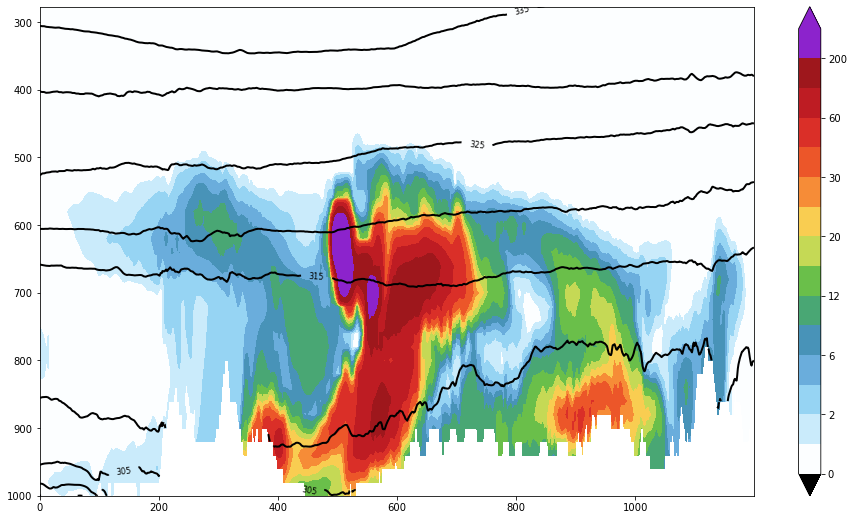

In [17]:
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.gca() 

contour = ax.contourf(
    cross["index"],
    cross["isobaric"],
    massden,
    levels=clevels,
    colors=ccolors,
    extend="both",
)
contour.cmap.set_under("k")
contour.cmap.set_bad("black", 1.)
colorbar = fig.colorbar(contour)

theta_contour = ax.contour(
    cross["index"],
    cross["isobaric"],
    potential_temperature,
    levels=np.arange(250, 450, 5),
    colors="k",
    linewidths=2,
)
theta_contour.clabel(
    theta_contour.levels[1::2],
    fontsize=8,
    colors="k",
    inline=1,
    inline_spacing=8,
    fmt="%i",
    rightside_up=True,
    use_clabeltext=True,
)

# Flip the y-axis
ax.set_yticklabels(np.arange(1000, 277, -100))
ax.set_ylim(1000, 277)
ax.set_yticks(np.arange(1000, 277, -100))

## Export

Export the cross-section data as a JSON file for prototyping the chart on the frontend. We'll use [d3-contour](https://github.com/d3/d3-contour/tree/v3.0.1) to build the chart, so we need to convert our 2D arrays to 1D arrays and provide the original shape of the matrix.

First we calculate the distance between the start and end points of this cross-section, which we'll need to display on the x-axis of the chart.

In [18]:
EARTH_EQUATORIAL_RADIUS_M = 6371229.0

In [19]:
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=EARTH_EQUATORIAL_RADIUS_M)
geod = ccrs.Geodetic(globe).get_geod()

In [20]:
_, _, distance = geod.inv(startPoint[1], startPoint[0], endPoint[1], endPoint[0])
distance

1165336.682360493

Next we prep the results for writing out to JSON. We'll need to strip all of the `NaN` values from our results and replace with `None`, which will serialize to a JavaScript `null`.

In [21]:
def prep_json(arr):
    """ Return a sanitized np.array with NaN values replaced by None """
    return np.where(np.isnan(arr), None, arr)

In [22]:
n, m = massden.shape

In [23]:
result = {
    "massden": np.ravel(prep_json(massden)).tolist(),
    "potentialTemperature": prep_json([quantity.magnitude for quantity in np.ravel(potential_temperature)]).tolist(),
    "isobaricPressure": prep_json(cross["isobaric"].values).tolist(),
    "distance": distance,
    "n": n,
    "m": m,
}

In [24]:
with open("data/sample.json", "w") as f:
    json.dump(result, f)